# REIT Assessment

The goal is to find very high dividend REITs that we will split our money between them. In order to do that I asked GPT to provide me with the list of highest dividend reits then I find their covariance matrices and use that as a metric for clustering. Particularly we use inverse covariance as a distance metric. Then we use a clustering algorithm to cluster the REITs based on their similatiry. The least related REITs are clustered together. Ideally one should perform a fundamentals analysis and pick the REITs that are the least correlated while also have very good fundamentals (indeally one per cluster.)

In [3]:
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.fundamentaldata import FundamentalData
import pandas as pd
import numpy as np
import time
import os

In [4]:
API_KEY = os.getenv('ALPHA_VANTAGE_API_KEY')
ts = TimeSeries(key=API_KEY, output_format='pandas')
fd = FundamentalData(key=API_KEY, output_format='pandas')

tickers = ['AGNC', 'NLY', 'OHI', 'ARR', 'LTC', 'IIPR', 'ORC', 'CHCT', 'ABR', 'PMT']

price_data = {}
fundamental_data = {}

for symbol in tickers:
    try:
        # Fetch daily adjusted close price
        df, _ = ts.get_daily_adjusted(symbol=symbol, outputsize='full')
        df = df[['5. adjusted close']].rename(columns={'5. adjusted close': symbol})
        price_data[symbol] = df

        # Fetch fundamentals
        overview, _ = fd.get_company_overview(symbol)
        fundamental_data[symbol] = overview.T

        time.sleep(12)  # Respect API limits (5 requests/minute)
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")

# Combine price data to aligned date index
prices = pd.concat(price_data.values(), axis=1, join='inner')
prices.index = pd.to_datetime(prices.index)
prices.sort_index(inplace=True)

# Compute log returns
returns = np.log(prices / prices.shift(1)).dropna()

# Compute normalized covariance matrix
cov_matrix = returns.cov()

# Save outputs
prices.to_csv('reit_prices.csv')
returns.to_csv('reit_returns.csv')
cov_matrix.to_csv('reit_covariance_matrix.csv')

# Combine and save fundamental data
fundamentals_df = pd.concat(fundamental_data.values(), axis=1)
fundamentals_df.columns = tickers
fundamentals_df.to_csv('reit_fundamentals.csv')


In [5]:
fundamentals_df

,AGNC,NLY,OHI,ARR,LTC,IIPR,ORC,CHCT,ABR,PMT
Symbol,AGNC,NLY,OHI,ARR,LTC,IIPR,ORC,CHCT,ABR,PMT
AssetType,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock,Common Stock
Name,AGNC Investment Corp,Annaly Capital Management Inc,Omega Healthcare Investors Inc,ARMOUR Residential REIT Inc,LTC Properties Inc,Innovative Industrial Properties Inc,Orchid Island Capital Inc.,Community Healthcare Trust Inc,Arbor Realty Trust,PennyMac Mortgage Investment Trust
Description,AGNC Investment Corp. The company is headquart...,"Annaly Capital Management, Inc., a diversified...",Omega is a real estate investment trust that i...,"ARMOR Residential REIT, Inc. invests in reside...",LTC is a real estate investment trust (REIT) t...,"Innovative Industrial Properties, Inc. is a se...","Orchid Island Capital, Inc., a specialty finan...",Community Healthcare Trust Incorporated is a r...,"Arbor Realty Trust, Inc. invests in a diversif...","PennyMac Mortgage Investment Trust, a specialt..."
CIK,1423689,1043219,888491,1428205,887905,1677576,1518621,1631569,1253986,1464423
Exchange,NASDAQ,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE,NYSE
Currency,USD,USD,USD,USD,USD,USD,USD,USD,USD,USD
Country,USA,USA,USA,USA,USA,USA,USA,USA,USA,USA
Sector,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION,REAL ESTATE & CONSTRUCTION
Industry,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS,REAL ESTATE INVESTMENT TRUSTS


In [15]:
spearman_corr = returns.corr(method='spearman')
kendall_corr = returns.corr(method='kendall')
linear_corr = returns.corr()

In [22]:
linear_corr

,AGNC,NLY,OHI,ARR,LTC,IIPR,ORC,CHCT,ABR,PMT
AGNC,1.000000,0.862547,0.416063,0.803729,0.499886,0.365958,0.694043,0.423848,0.610355,0.594074
NLY,0.862547,1.000000,0.443201,0.790643,0.552828,0.354761,0.717091,0.470542,0.643834,0.655833
OHI,0.416063,0.443201,1.000000,0.471416,0.751858,0.332501,0.472371,0.601847,0.450217,0.488385
ARR,0.803729,0.790643,0.471416,1.000000,0.551153,0.389079,0.789492,0.476315,0.692994,0.694273
LTC,0.499886,0.552828,0.751858,0.551153,1.000000,0.365985,0.520733,0.651450,0.465598,0.480158
IIPR,0.365958,0.354761,0.332501,0.389079,0.365985,1.000000,0.347612,0.364599,0.369021,0.362321
ORC,0.694043,0.717091,0.472371,0.789492,0.520733,0.347612,1.000000,0.467265,0.587183,0.664112
CHCT,0.423848,0.470542,0.601847,0.476315,0.651450,0.364599,0.467265,1.000000,0.388669,0.451188
ABR,0.610355,0.643834,0.450217,0.692994,0.465598,0.369021,0.587183,0.388669,1.000000,0.614482
PMT,0.594074,0.655833,0.488385,0.694273,0.480158,0.362321,0.664112,0.451188,0.614482,1.000000


<Axes: xlabel='date'>

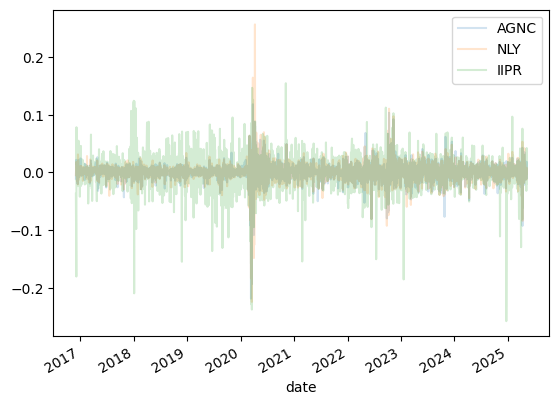

In [20]:
returns[['AGNC', 'NLY', 'IIPR']].plot(alpha=0.2)

In [24]:
from sklearn.covariance import GraphicalLassoCV
import numpy as np

# X: rows = time steps (samples), columns = assets
X = returns[tickers].to_numpy()

# Standardize data (optional but common)
X -= X.mean(axis=0)
X /= X.std(axis=0)

# Fit Graphical Lasso with cross-validated alpha
model = GraphicalLassoCV(alphas=np.logspace(-2, 2, 20))
model.fit(X)

# The estimated sparse inverse covariance matrix (precision)
precision_matrix = model.precision_
# The estimated covariance matrix
covariance_matrix = model.covariance_


In [31]:
from sklearn import cluster

_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
symbols = np.array(tickers)

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(symbols[labels == i])}")

Cluster 1: AGNC, NLY, ARR, ORC, ABR, PMT
Cluster 2: OHI, LTC, CHCT
Cluster 3: IIPR


In [32]:
from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=2
)

embedding = node_position_model.fit_transform(X.T).T

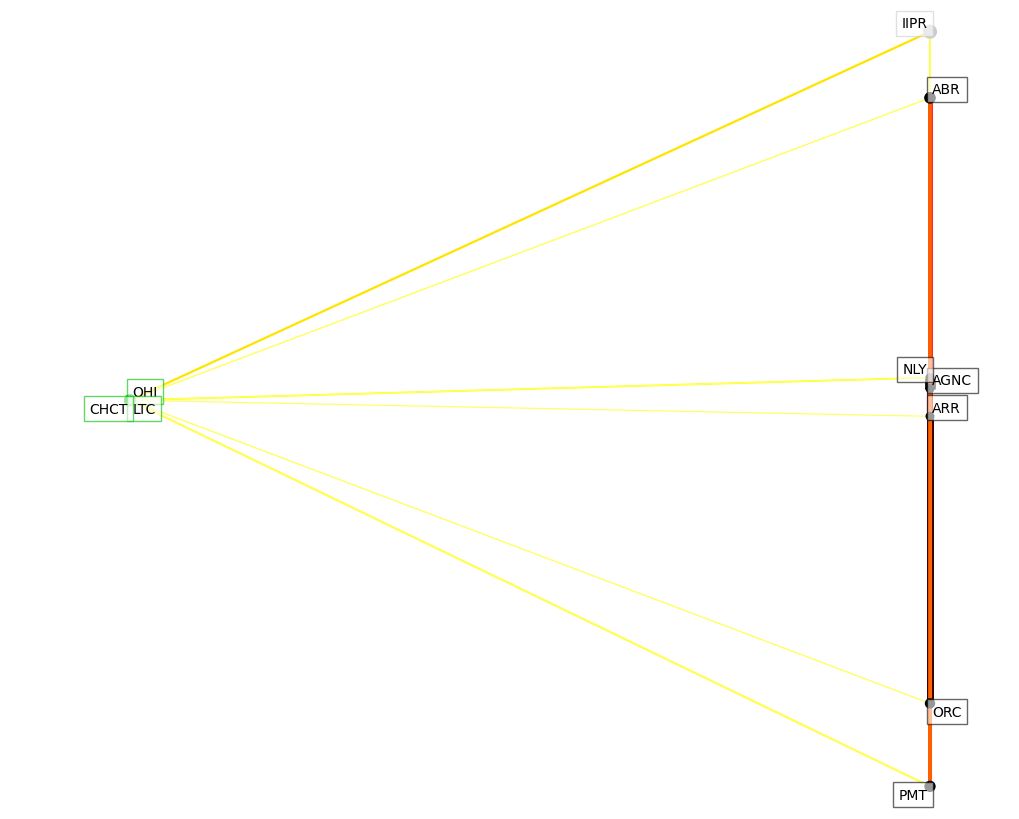

In [34]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()